In [86]:
from kdap.converter.wikiConverter import wikiConverter
import xmltodict
from datetime import date
import mwparserfromhell
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [87]:
article = 'Indian Institute of Technology Ropar'
wikiConverter.getArticle(file_name = article, output_dir = 'wiki')

Indian Institute of Technology Ropar Completed!


In [88]:
f = open("botList.txt",'r')
bots = [ x.rstrip('\n') for x in list(f.readlines())]

In [89]:
class wikiStats :
    
    #GENERAL STATISTICS
    def __init__(self, article) :
        self.di = xmltodict.parse(open('./wiki/'+article+'.xml',"r").read())
        self.revisions = [x for x in self.di['mediawiki']['page']['revision']] 
        self.editors = {}
        self.botEditors = {}
        for x in self.revisions :
            username = x['contributor']['username'] if 'username' in x['contributor'] else x['contributor']['ip']
            if username not in bots:
                if username in self.editors :
                    self.editors[username] += 1
                else :
                    self.editors[username] = 1
            else :
                if username in self.botEditors :
                    self.botEditors[username] += 1
                else :
                    self.botEditors[username] = 1 

    def getID(self) :
        return self.di['mediawiki']['page']['id']
            
    def getTotalEdits(self) :
        return len(self.revisions) 
    
    def getMinorEdits(self) :
        i = 0
        for x in self.revisions :
            if 'minor' in x :
                i += 1
        return i
    
    def getIPEdits(self) :
        i = 0
        for x in self.revisions :
            if 'ip' in x['contributor'] :
                i += 1
        return i
    
    def getBotEdits(self) :
        ans = 0
        for bot in self.botEditors.keys() :
            ans += self.botEditors[bot]
        return ans
    
    def getEditors(self) :
        return len(self.editors) + len(self.botEditors)
    
    def getPageSize(self) :
        return self.revisions[-1]['text']['@bytes']
    
    def getFirstEdit(self) :
        di = {}
        di['user'] = self.revisions[0]['contributor']['username'] if 'username' in self.revisions[0]['contributor'] else self.revisions[0]['contributor']['ip']
        di['time'] = self.revisions[0]['timestamp']
        di['text added'] = self.revisions[0]['text']['@bytes']
        return di
    
    def getLastEdit(self) :
        di = {}
        di['user'] = self.revisions[-1]['contributor']['username'] if 'username' in self.revisions[-1]['contributor'] else self.revisions[-1]['contributor']['ip']
        di['time'] = self.revisions[-1]['timestamp']
        try :
            di['text added'] = int(self.revisions[-1]['text']['@bytes']) - int(self.revisions[-2]['text']['@bytes'])
        except :
            di['text added'] = self.revisions[0]['text']['@bytes']
        return di
    
    def getMaxTextAdded(self) :
        di = {}
        di['user'] = self.revisions[0]['contributor']['username'] if 'username' in self.revisions[0]['contributor'] else self.revisions[0]['contributor']['ip']
        di['time'] = self.revisions[0]['timestamp']
        di['text added'] = int(self.revisions[0]['text']['@bytes'])
        for i in range(1, len(self.revisions)) :
            temp = int(self.revisions[i]['text']['@bytes']) - int(self.revisions[i-1]['text']['@bytes'])
            if temp > di['text added'] :
                di['user'] = self.revisions[i]['contributor']['username'] if 'username' in self.revisions[i]['contributor'] else self.revisions[i]['contributor']['ip']
                di['time'] = self.revisions[i]['timestamp']  
                di['text added'] = temp
        return di
    
    def getMaxTextDeleted(self) :
        di = {}
        di['text deleted'] = 0
        for i in range(1, len(self.revisions)) :
            temp = int(self.revisions[i]['text']['@bytes']) - int(self.revisions[i-1]['text']['@bytes'])
            if temp < di['text deleted'] :
                di['user'] = self.revisions[i]['contributor']['username'] if 'username' in self.revisions[i]['contributor'] else self.revisions[i]['contributor']['ip']
                di['time'] = self.revisions[i]['timestamp']  
                di['text deleted'] = temp
        return di
    
    #EDITS 
    def getAverageEditsPerUser(self) :
        return self.getTotalEdits()/self.getEditors()
    
    def getAverageTimeBetweenEdits(self) :
        timestamps = [ di['mediawiki']['page']['revision'][i]['timestamp'] for i in range(len(di['mediawiki']['page']['revision']))]
        times = [date(year = int(timestamps[i][:4]), month = int(timestamps[i][5:7]), day = int(timestamps[i][8:10])) for i in range(len(timestamps))]
        timeDiff = date(1, 1, 1) - date(1, 1, 1)
        for i in range(len(times)-1) :
            timeDiff += times[i+1] - times[i]
        return timeDiff.days/(len(times)-1)
    
    def getAverageEditsPerDay(self) :
        t1 = self.getFirstEdit()['time']
        t1 = date(year = int(t1[:4]), month = int(t1[5:7]), day = int(t1[8:10]))
        t2 = datetime.date.today()
        return self.getTotalEdits()/(t2-t1).days
    
    def getAverageEditsPerMonth(self) :
        return 30*self.getAverageEditsPerDay()
    
    def getAverageEditsPerYear(self) :
        return 365*self.getAverageEditsPerDay()
    
    def getEditsInPastXDays(self, x) :
        timestamps = [ di['mediawiki']['page']['revision'][i]['timestamp'] for i in range(len(di['mediawiki']['page']['revision']))]
        times = [date(year = int(timestamps[i][:4]), month = int(timestamps[i][5:7]), day = int(timestamps[i][8:10])) for i in range(len(timestamps))]
        t0 = datetime.date.today()
        count = 0
        for i in range(len(times)-1, -1, -1) :
            t = times[i]
            tDiff = t0 - t
            if tDiff.days > x :
                break
            else :
                count += 1
        return count
        
    def getEditsInPast24Hours(self) :
        return self.getEditsInPastXDays(x = 1)
    
    def getEditsInPast7Days(self) :
        return self.getEditsInPastXDays(x = 7)
        
    def getEditsInPast30Days(self) :
        return self.getEditsInPastXDays(x = 30)
    
    def getEditsInPast365Days(self) :
        return self.getEditsInPastXDays(x = 365)
    
    def getEditsByTop10Editors(self) :
        arr = []
        for x in self.editors.keys() :
            arr.append(self.editors[x])
        arr.sort(reverse = True)
        top10Edits = 0
        for i in range(10) :
            try :
                top10Edits += arr[i]
            except :
                break
        return top10Edits
    
    #charts
    def getMajorMinorGraph(self) :
        labels = ["Major edits","Minor Edits"]
        values = [self.getTotalEdits() - self.getMinorEdits(), self.getMinorEdits()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i])

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, autopct = '%0.1f%%', startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
    
    def getAccountIPGraph(self) :
        labels = ["Accounts","IPs"]
        values = [self.getTotalEdits() - self.getIPEdits(), self.getIPEdits()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i])

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, autopct = '%0.1f%%', startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
        
    def getTop10Bottom90Graph(self) :
        labels = ["Top 10% ","Bottom 90%"]
        values = [self.getEditsByTop10Editors(), self.getTotalEdits() - self.getEditsByTop10Editors()]
        colors = ['#abd4eb', "#b2df8a"]
        explode = [0.01, 0.01]
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i])

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, colors = colors, explode = explode, autopct = '%0.1f%%', startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
    
    def modifyEditors(self) :
        editorsArray = []
        for x in self.editors.keys() :
            di ={}
            di["username"] = x
            di["total edits"] = 0
            di["minor edits"] = 0
            di["first edit"] = None
            di["latest edit"] = None
            di["bytes added"] = 0
            editorsArray.append(di)
        
        for i in range(len(self.revisions)) :
            x = self.revisions[i]
            username = x['contributor']['username'] if 'username' in x['contributor'] else x['contributor']['ip']
            for editor in editorsArray :
                if editor["username"] == username :
                    editor["total edits"] += 1
                    editor["minor edits"] += 1 if 'minor' in x else 0
                    if editor["first edit"] == None :
                        editor["first edit"] = x['timestamp']
                    editor["latest edit"] = x['timestamp']
                    if i != 0 :
                        editor["bytes added"] += max(0, int(self.revisions[i]['text']['@bytes']) - int(self.revisions[i-1]['text']['@bytes']))
                    else :
                        editor["bytes added"] += int(x['text']['@bytes'])
        return editorsArray
    
    def getTop10ByEditsGraph(self) :
        editors = self.modifyEditors()
        editors.sort(key = lambda x: x["total edits"], reverse = True)
        
        labels = [editors[i]["username"] for i in range(min(10, len(editors))) ]
        values = [editors[i]["total edits"] for i in range(len(labels))]
        colors = [ '#abd4eb', "#b2df8a", '#fb9a99', '#f3bf6f', '#cab2d6', '#cfb680', '#8dd3c7', '#fccde5', '#fff7a1', '#fc9272' ]
        explode = [0.01 for i in range(len(labels)) ]
        
        total = 0
        for value in values :
            total += value
            
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i]) + " (" + "{0:.1f}".format(100*values[i]/total) + ")%"

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.pie(values, radius = 1.5, colors = colors, explode = explode, startangle=90, counterclock = False)
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()
        
    def getTop10ByAddedTextGraph(self) :
        editors = self.modifyEditors()
        editors.sort(key = lambda x: x["bytes added"], reverse = True)
        
        labels = [editors[i]["username"] for i in range(min(10, len(editors))) ]
        values = [editors[i]["bytes added"] for i in range(len(labels))]
        colors = [ '#abd4eb', "#b2df8a", '#fb9a99', '#f3bf6f', '#cab2d6', '#cfb680', '#8dd3c7', '#fccde5', '#fff7a1', '#fc9272' ]
        explode = [0.01 for i in range(len(labels)) ]
        plt.pie(values, radius = 1.5, colors = colors, explode = explode, startangle=90, counterclock = False)
 
        total = 0
        for value in values :
            total += value
             
        for i in range(len(labels)) :
            labels[i] = labels[i] + " · " + str(values[i]) + " (" + "{0:.1f}".format(100*values[i]/total) + ")%"

        legend_elements = [ Line2D([0], [0], marker='o', color='w', markersize=15,
                    label=labels[i],  markerfacecolor=colors[i]) for i in range(len(labels))]

        plt.axis("equal")
        plt.legend(labels, handles=legend_elements, loc="center left", fontsize = 12, frameon = False, bbox_to_anchor=(1, 0, 0.5, 1))

        plt.show()

In [90]:
stats = wikiStats(article)

In [91]:
stats.getBotEdits()

34

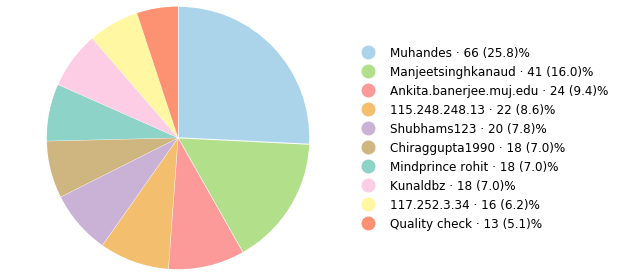

In [92]:
stats.getTop10ByEditsGraph()

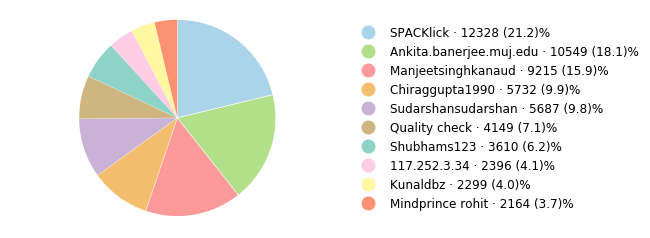

In [93]:
stats.getTop10ByAddedTextGraph()

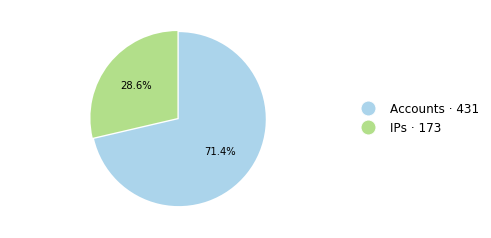

In [94]:
stats.getAccountIPGraph()

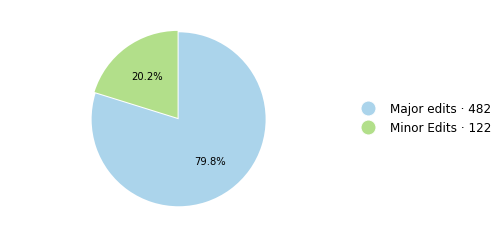

In [95]:
stats.getMajorMinorGraph()

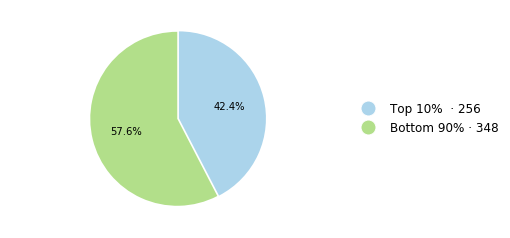

In [96]:
stats.getTop10Bottom90Graph()

In [ ]:
di = xmltodict.parse(open('./wiki/'+article+'.xml',"r").read())
text = di['mediawiki']['page']['revision'][-1]['text']['#text']
wikicode = mwparserfromhell.parse(text)

In [ ]:
di = xmltodict.parse(open('./wiki/'+article+'.xml',"r").read())
revisions = [x for x in di['mediawiki']['page']['revision']]

In [ ]:
revisions[0]['timestamp']

In [ ]:
i = 0
print(revisions[i]['contributor']['username'] if 'username' in revisions[i]['contributor'] else revisions[i]['contributor']['ip'])

In [ ]:
arr = [{'count':9},{'count':29},{'count':999}]

In [ ]:
for x in arr :
    if 